Policy Gradient 引申出的 REINFORCE 和 AC 算法都是 on-policy 的，演员去与环境交互搜集数据，搜集很多的轨迹 τ，根据搜集到的数据按照策略梯度的公式更新策略的参数。

策略梯度是一个会花很多时间来采样数据的算法，其大多数时间都在采样数据。所以我们想要从同策略变成异策略，这样就可以用另外一个策略去采样多一些的数据，让 $\theta$ 更新很多次。

因为是不同的策略，这才引入了重要性采样（importance sampling），也就是两个近似但不同的分布采样出来的动作。我们的学习策略没有直接访问（使用）采样策略，因此在学习更新时需要权重平衡。

$$\mathbb{E}_{x \sim p}[f(x)] = \int f(x) p(x) \mathrm{d} x=\int f(x) \frac{p(x)}{q(x)} q(x) \mathrm{d} x=\mathbb{E}_{x \sim q}\left[f(x) \frac{p(x)}{q(x)}\right]$$

理论上，任何的 p 和 q 都是没问题的，但是左右两侧的等式只保证了期望相等，没有对方差估计量进行刻画。

$$\operatorname{Var}[X] = E\bigl[X^2\bigr] - \bigl(E[X]\bigr)^2$$

实际上，左右的两个分布在方差上随着 p 和 q 的不同而不同。两个随机变量的平均值相同，并不代表它们的方差相同。看下面的公式很容易发现，差别在于第一项是不同的，如果 p 和 q 差别大自然方差就会不同。

$$
\operatorname{Var}_{x\sim p}[f(x)]
= \mathbb{E}_{x\sim p}\bigl[f(x)^2\bigr]
- \bigl(\mathbb{E}_{x\sim p}[f(x)]\bigr)^2
$$

$$
\operatorname{Var}_{x\sim q}\!\Bigl[\frac{f(x)\,p(x)}{q(x)}\Bigr]
= \mathbb{E}_{x\sim q}\!\Bigl[\Bigl(\frac{f(x)\,p(x)}{q(x)}\Bigr)^2\Bigr]
- \Bigl(\mathbb{E}_{x\sim q}\!\bigl[\tfrac{f(x)\,p(x)}{q(x)}\bigr]\Bigr)^2
$$

$$
\qquad\quad
= \mathbb{E}_{x\sim p}\!\Bigl[f(x)^2\,\frac{p(x)}{q(x)}\Bigr]
- \bigl(\mathbb{E}_{x\sim p}[f(x)]\bigr)^2
$$

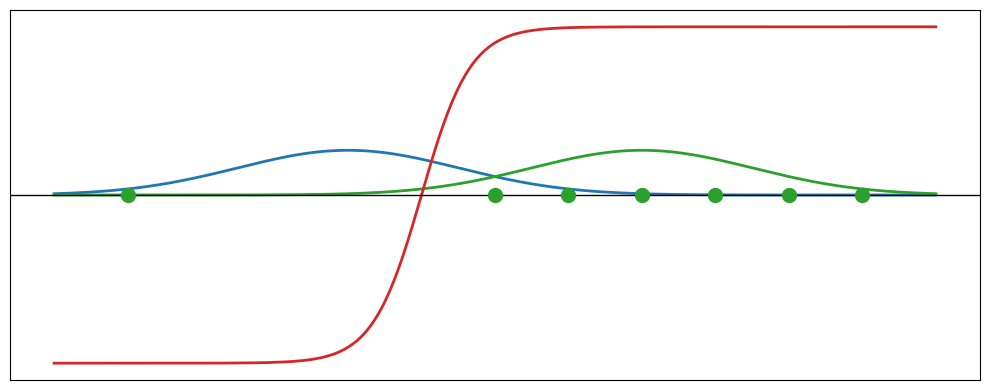

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create x-range
x = np.linspace(-4, 8, 400)

# Define p(x) and q(x) as Gaussian mixtures
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))

p = gaussian(x, mu=0, sigma=1.5)
q = gaussian(x, mu=4, sigma=1.5)

# Define f(x) as a smooth sigmoid-like function
f = np.tanh((x - 1) * 1.5)

# Sample points for importance weights
samples_p = np.linspace(-3, -1, 1)   # one sample on left
samples_q = np.linspace(2, 7, 6)     # six samples on right

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(x, p, label='p(x)', color='tab:blue', linewidth=2)
plt.plot(x, q, label='q(x)', color='tab:green', linewidth=2)
plt.plot(x, f, label='f(x)', color='tab:red', linewidth=2)

# Horizontal axis
plt.axhline(0, color='black', linewidth=1)

# Sample markers on x-axis
plt.scatter(samples_p, np.zeros_like(samples_p), color='tab:green', s=100, zorder=5)
plt.scatter(samples_q, np.zeros_like(samples_q), color='tab:green', s=100, zorder=5)

# Cleaning up (no text labels, ticks only)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

如上图就是一个很好的例子。蓝色线是 p(x)，绿线是 q(x)，红线是 f(x)。我们的做法是用 $\mathbb{E}_{x \sim q}\left[f(x) \frac{p(x)}{q(x)}\right]$ 去替代 $\mathbb{E}_{x \sim p}[f(x)]$。可以看到，从 p 做采样肯定是负的。但如果在 q 分布中采样的点不够多，全都采样在非长尾区域，就会得出期望是正数的结论。只有继续采样，才能采样到长尾中的样本，这是该样本的 p(x)/q(x) 会有很大的权重，这样就可以平衡刚才那边一直采样到正的值的情况。

$$
\nabla \bar{R}_{\theta}=\mathbb{E}_{\tau \sim p_{\theta^{\prime}(\tau)}}\left[\frac{p_{\theta}(\tau)}{p_{\theta^{\prime}}(\tau)} R(\tau) \nabla \log p_{\theta}(\tau)\right]
$$
$$
\mathbb{E}_{\left(s_{t}, a_{t}\right) \sim \pi_{\theta^{\prime}}}\left[\frac{p_{\theta}\left(a_{t} \mid s_{t}\right)}{p_{\theta^{\prime}}\left(a_{t} \mid s_{t}\right)} A^{\theta^{\prime}}\left(s_{t}, a_{t}\right) \nabla \log p_{\theta}\left(a_{t}^{n} \mid s_{t}^{n}\right)\right]
$$

我们可以从梯度反推原来的目标函数
$$\nabla f(x)=f(x) \nabla \log f(x)$$
注意此时和 $\theta^{\prime}$ 相关的 term 都是常数，因此有
$$J^{\theta^{\prime}}(\theta)=\mathbb{E}_{\left(s_{t}, a_{t}\right) \sim \pi_{\theta^{\prime}}}\left[\frac{p_{\theta}\left(a_{t} \mid s_{t}\right)}{p_{\theta^{\prime}}\left(a_{t} \mid s_{t}\right)} A^{\theta^{\prime}}\left(s_{t}, a_{t}\right)\right]$$

PPO 和 TRPO 解决的是

$$
J_{\mathrm{PPO}}^{\theta^{k}}(\theta)=J^{\theta^{k}}(\theta)-\beta \operatorname{KL}\left(\theta, \theta^{k}\right)
$$

自适应 KL 惩罚（adaptive KL penalty）
- 如果 $\mathrm{KL}\left(\theta, \theta^{k}\right)>\mathrm{KL}_{\max }$，增大 $\beta$
- 如果 $\mathrm{KL}\left(\theta, \theta^{k}\right)<\mathrm{KL}_{\max }$，减小 $\beta$

近端策略优化惩罚可表示为
$$
\begin{array}{l}J_{\mathrm{PPO}}^{\theta^{k}}(\theta)=J^{\theta^{k}}(\theta)-\beta \operatorname{KL}\left(\theta, \theta^{k}\right) \\J^{\theta^{k}}(\theta) \approx \sum_{\left(s_{t}, a_{t}\right)} \frac{p_{\theta}\left(a_{t} \mid s_{t}\right)}{p_{\theta^{k}}\left(a_{t} \mid s_{t}\right)} A^{\theta^{k}}\left(s_{t}, a_{t}\right)\end{array}
$$

近端策略优化裁剪的目标函数里面没有 KL 散度，其要最大化的目标函数为
$$
\begin{aligned}J_{\mathrm{PPO} 2}^{\theta^{k}}(\theta) \approx \sum_{\left(s_{t}, a_{t}\right)} \min & \left(\frac{p_{\theta}\left(a_{t} \mid s_{t}\right)}{p_{\theta^{k}}\left(a_{t} \mid s_{t}\right)} A^{\theta^{k}}\left(s_{t}, a_{t}\right)\right. \\& \left.\operatorname{clip}\left(\frac{p_{\theta}\left(a_{t} \mid s_{t}\right)}{p_{\theta^{k}}\left(a_{t} \mid s_{t}\right)}, 1-\varepsilon, 1+\varepsilon\right) A^{\theta^{k}}\left(s_{t}, a_{t}\right)\right)\end{aligned}
$$

说白了，当优势大于 0 时，如果学习策略在某个 token 或动作上的预测概率大幅提升，以至于大过了阈值，那么此时会限制该提升；也就是说，虽然这个动作很有优势，但也不能允许新分布的概率与老的差异太大了；同理，当优势小于 0 时，如果某个 token 的预测概太率会下降，也需要限制该下降的程度（尽管这是一个好的优化方向）。

In [1]:
import torch
import torch.nn.functional as F

eps = 0.2
log_probs = F.log_softmax(torch.randn(2, 8), dim=1)
old_log_probs = F.log_softmax(torch.randn(2, 8), dim=1)
advantages = torch.randn(2, 8)

ratio = (log_probs - old_log_probs).exp()
surr1 = ratio * advantages
surr2 = torch.clamp(ratio, 1 - eps, 1 + eps) * advantages

-torch.min(surr1, surr2).mean(dim=0)

tensor([ 0.0750,  1.1644, -0.7275,  1.8153, -0.3329, -0.6741,  0.2278, -0.4762])